### Experiment: compute PSD parameter via spectral moments


The method is taken from:
> Lai, Shih-Sheng Paul. "Statistical characterization of strong ground motions using power spectral density function." Bulletin of the Seismological Society of America 72.1 (1982): 259-274.


**KT model parameters are:**
- $G_{0}$, intensity of the ideal white noise excitation at the bedrock-overburden interface;
- $\zeta_{g}$, soil overburden effective damping coefficient;
- $\omega_{g}$, natural frequency;



**Lai proposed empirical rules to obtain these parameters:**
1. It's reasonable to assume a constant $\zeta_{g}$ value of 0.32
2. a mean value of $\omega_{g}$ to be 20.3 rad/s

In [1]:
import sympy as sp
import numpy as np
from sympy import solve_poly_system

import sys
sys.path.append('/Users/leslie/Documents/GitHub_repos/')
from KT_model import *

sys.path.append('/Users/leslie/Documents/GitHub_repos/ImputeIntervalGM/LeslieModules/')
from utils import Spectral_moments
from PSD_estimators_module import periodogram_estimator

## First part, load in an real accelerogram

#### 1. Parametrize the KT model

In [2]:
# np.random.seed(9527)
w_kt = np.linspace(-wu, wu, 1000)

In [3]:
G0=0.01442
zeta_g =0.32
omega_g = 28.39

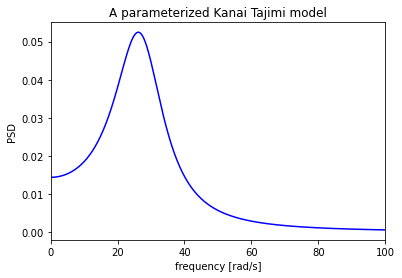

In [4]:
# visually check the KT model
plt.figure(figsize=(6,4))
plt.plot(w_kt, parameterize_KT_model(w_kt, wg=omega_g, zzeta =zeta_g, S0=G0), color='blue')
plt.xlim([0, wu])
plt.title('A parameterized Kanai Tajimi model')
plt.xlabel('frequency [rad/s]')
plt.ylabel('PSD');

#### 2. Use Spectral Representation method to get a realization

In [5]:
# set up a Fs=50, for example
FS=100

# length of the simulated signal, in seconds
DURATION = 16

# return our simulated signal
t, simulation = SpecRepsentation(FS, DURATION)

the length of the simulation (1600,)


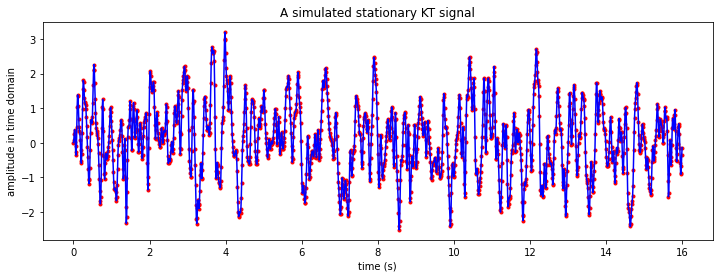

In [6]:
# plot the simulated signal
plt.figure(figsize=(12,4))
plt.plot(t, simulation, '.r', t, simulation, '-b')
plt.title('A simulated stationary KT signal')
plt.xlabel('time (s)')
plt.ylabel('amplitude in time domain');

#### 3. compute the realization's spectral moments, i.e., $\lambda_{0}, \lambda_{1}, \lambda_{2}$

In [7]:
def Spectral_moments(w_axis, PSD_rads, freq_lmt=25*np.pi):
    """
    SRM, but below is used by me using hz.
    But SRM is defined in rads;
    :freq_lmt, the upper limit 25pi
    """
    delta_w = w_axis[1] - w_axis[0]

    # the integral upper limit
    the_limit = np.sum(w_axis < freq_lmt)

    lamda_zero = np.sum((delta_w * PSD_rads)[:the_limit])
    lamda_1st = np.sum((delta_w * PSD_rads * w_axis)[:the_limit])
    lamda_2nd = np.sum((delta_w * PSD_rads * w_axis * w_axis)[:the_limit])
    central_freq = np.sqrt(lamda_2nd / lamda_zero)
    shape_factor = np.sqrt(1 - (lamda_1st**2 / (lamda_zero * lamda_2nd)))

    return {'l0': lamda_zero, 'l1': lamda_1st, 'l2': lamda_2nd, 'cfreq':central_freq, 'sfactor': shape_factor}

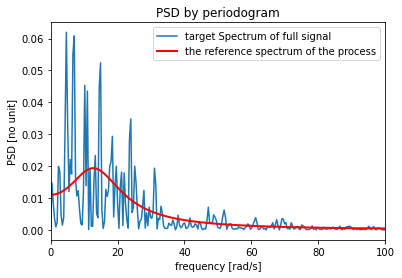

In [8]:
w, PSD = periodogram_estimator(simulation, 
                               fs=FS, 
                               plotting=True, 
                               get_spectrum=True, 
                               label_name='target Spectrum of full signal')

plot_reference_spectrum(w_kt, wu)

In [9]:
a_specm_dict = Spectral_moments(w, PSD, freq_lmt=100)

In [10]:
a_specm_dict

{'l0': 0.523562516689669,
 'l1': 10.481943124016126,
 'l2': 379.71073706092375,
 'cfreq': 26.930360408351266,
 'sfactor': 0.6688308687057914}

#### 4. Estimating PSD parameters by spectral moments matching

In [ ]:
G0 = sp.Symbol('G0')
zeta_g = sp.Symbol('zeta_g')
omega_g = sp.Symbol('omega_g')

In [ ]:
OMEGA = 25 * sp.pi / omega_g
print(OMEGA)

In [ ]:
# try a forward pass

# G0=0.011
# zeta_g =0.63
# omega_g = 5*np.pi

In [11]:
OMEGA = 100 * np.pi / omega_g
print(OMEGA)

11.065842386719948


**some bridge variables**

In [12]:
J0 = (1 / sp.pi) * sp.atan((2 * zeta_g * OMEGA) / (1 - OMEGA**2)) + \
     (zeta_g)/(2 * sp.pi * sp.sqrt(1 - zeta_g**2)) * sp.ln((1 + 2*OMEGA*sp.sqrt(1 - zeta_g**2)+OMEGA**2) / (1-2*OMEGA*sp.sqrt(1 - zeta_g**2)+OMEGA**2))


In [13]:
J1 = 1 / (sp.pi*sp.sqrt(1 - zeta_g**2)) * sp.atan((2*zeta_g*sp.sqrt(1 - zeta_g**2))/(1-2*zeta_g**2-OMEGA**2))


In [14]:
J2 =  (1 / sp.pi) * sp.atan((2 * zeta_g * OMEGA) / (1 - OMEGA**2)) - \
     (zeta_g)/(2 * sp.pi * sp.sqrt(1 - zeta_g**2)) * sp.ln((1 + 2*OMEGA*sp.sqrt(1 - zeta_g**2)+OMEGA**2)/(1-2*OMEGA*sp.sqrt(1 - zeta_g**2)+OMEGA**2))


In [15]:
J3 =  zeta_g/sp.pi * sp.log((1-OMEGA**2)**2 + 4*(zeta_g**2)*OMEGA**2) + \
     (1 - 2*zeta_g**2)/(sp.pi*sp.sqrt(1 - zeta_g**2)) * sp.atan((2*zeta_g*sp.sqrt(1 - zeta_g**2))/(1-2*zeta_g**2-OMEGA**2))


In [16]:
J4 = 4*zeta_g/sp.pi*OMEGA + 2 * (1-2*zeta_g)**2 * J2 - J0

**solving the equation**

In [17]:
# lambda_0
l0 = (sp.pi * G0 * omega_g)/(4 * zeta_g) * J0 * (1 + 4 * zeta_g**2)

In [18]:
# lambda_1
l1 = (sp.pi * G0 * omega_g**2)/(4 * zeta_g) * \
     (J1+4 * zeta_g**2 * J3 - (((1+4*zeta_g**2-8*zeta_g**4)/(sp.pi*sp.sqrt(1-zeta_g**2))) * sp.atan((2*zeta_g*sp.sqrt(1-2*zeta_g**2))/(1-2*zeta_g**2))))

In [19]:
# lambda_2
l2 = (sp.pi * G0 * omega_g**3)/(4 * zeta_g) * (J2 + 4*zeta_g**2*J4)

In [20]:
# correpsonding to a forward pass
l0

-0.000143067821671208

In [21]:
np.sqrt(0.0103250179416207)

0.10161209544941341

In [22]:
l1

3.45558621308842

In [23]:
l2

1462.47340114062

In [ ]:
solved_value = sp.solve([l0 - a_specm_dict['l0'] , l1 - a_specm_dict['l1'], l2 - a_specm_dict['l2']], (G0, zeta_g, omega_g))

In [ ]:
print(solved_value)

In [ ]:
print(l0)

In [ ]:
print(l1)

In [ ]:
print(l2)